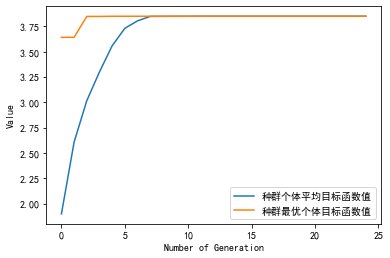

种群信息导出完毕。
最优的目标函数值为：3.850272716105895
最优的控制变量值为：
1.8505813776055176
有效进化代数：25
最优的一代是第 11 代
评价次数：1000
时间已过 0.014984607696533203 秒


In [3]:
# -*- coding: utf-8 -*-
import numpy as np
import geatpy as ea # import geatpy

"""
该案例展示了一个简单的连续型决策变量最大化目标的单目标优化问题。
max f = x * np.sin(10 * np.pi * x) + 2.0
s.t.
-1 <= x <= 2
"""
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        M = 1 # 初始化M（目标维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 1 # 初始化Dim（决策变量维数）
        varTypes = [0] * Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [-1] # 决策变量下界
        ub = [2] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    
    def aimFunc(self, pop): # 目标函数
        x = pop.Phen # 得到决策变量矩阵
        pop.ObjV = x * np.sin(10 * np.pi * x) + 2.0 # 计算目标函数值，赋值给pop种群对象的ObjV属性
        
        
if __name__ == '__main__':
    """===============================实例化问题对象==========================="""
    problem = MyProblem() # 生成问题对象
    """=================================种群设置==============================="""
    Encoding = 'BG'       # 编码方式
    NIND = 40             # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """===============================算法参数设置============================="""
    myAlgorithm = ea.soea_SEGA_templet(problem, population) # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 25 # 最大进化代数
    """==========================调用算法模板进行种群进化======================="""
    [population, obj_trace, var_trace] = myAlgorithm.run() # 执行算法模板
    population.save() # 把最后一代种群的信息保存到文件中
    # 输出结果
    best_gen = np.argmin(problem.maxormins * obj_trace[:, 1]) # 记录最优种群个体是在哪一代
    best_ObjV = obj_trace[best_gen, 1]
    print('最优的目标函数值为：%s'%(best_ObjV))
    print('最优的控制变量值为：')
    for i in range(var_trace.shape[1]):
        print(var_trace[best_gen, i])
    print('有效进化代数：%s'%(obj_trace.shape[0]))
    print('最优的一代是第 %s 代'%(best_gen + 1))
    print('评价次数：%s'%(myAlgorithm.evalsNum))
    print('时间已过 %s 秒'%(myAlgorithm.passTime))

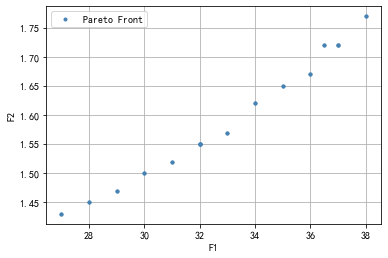

种群信息导出完毕。
用时：0.22039222717285156 秒
非支配个体数：30 个
单位时间找到帕累托前沿点个数：136 个


In [6]:
# -*- coding: utf-8 -*-
import numpy as np
import geatpy as ea

"""
一个带约束的多目标背包问题：
    假设有5类物品，每类物品中包含着四个具体的物品，要求从这五种类别的物品中分别选择一个物品放进背包，
使背包内的物品总价最高，总体积最小，且背包的总质量不能超过92kg。用矩阵P代表背包中物品的价值；
矩阵R代表背包中物品的体积；矩阵C代表物品的质量。P,R,C的取值如下:
P=[[3,4,9,15,2],      R=[[0.2, 0.3, 0.4, 0.6, 0.1],     C=[[10,13,24,32,4],
   [4,6,8,10,2.5],       [0.25,0.35,0.38,0.45,0.15],       [12,15,22,26,5.2],
   [5,7,10,12,3],        [0.3, 0.37,0.5, 0.5, 0.2],        [14,18,25,28,6.8],
   [3,5,10,10,2]]        [0.3, 0.32,0.45,0.6, 0.2]]        [14,14,28,32,6.8]]
分析：
    这是一个0-1背包问题，但如果用一个元素为0或1的矩阵来表示哪些物品被选中，则不利于后面采用进
化算法进行求解。可以从另一种角度对背包问题进行编码：由于问题要求在每类物品均要选出一件，这里我
们可以用0, 1, 2, 3来表示具体选择哪件物品。因此染色体可以编码为一个元素属于{0, 1, 2, 3}的1x5行向量，
比如：[0,0,0,0,0]表示从这五类物品中各选取第一个物品。
"""

class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self, M = 2):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        maxormins = [-1, 1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 5 # 初始化Dim（决策变量维数）
        varTypes = [1] * Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [0] * Dim # 决策变量下界
        ub = [3] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 添加几个属性来存储P、R、C
        self.P=np.array([[3,4,9,15,2],
                        [4,6,8,10,2.5],
                        [5,7,10,12,3],
                        [3,5,10,10,2]])
        self.R=np.array([[0.2,0.3,0.4,0.6,0.1],
                        [0.25,0.35,0.38,0.45,0.15],
                        [0.3,0.37,0.5,0.5,0.2],
                        [0.3,0.32,0.45,0.6,0.2]])
        self.C=np.array([[10,13,24,32,4],
                        [12,15,22,26,5.2],
                        [14,18,25,28,6.8],
                        [14,14,28,32,6.8 ]])
    
    def aimFunc(self, pop): # 目标函数
        x = pop.Phen.astype(int) # 得到决策变量矩阵
        f1 = np.sum(self.P[x, [0,1,2,3,4]], 1)
        f2 = np.sum(self.R[x, [0,1,2,3,4]], 1)
        # 采用可行性法则处理约束
        pop.CV = np.array([np.sum(self.C[x, [0,1,2,3,4]], 1)]).T - 92
        pop.ObjV = np.vstack([f1, f2]).T # 把求得的目标函数值赋值给种群pop的ObjV
        
if __name__ == '__main__':
    """===============================实例化问题对象============================"""
    problem = MyProblem()     # 生成问题对象
    """=================================种群设置==============================="""
    Encoding = 'BG'           # 编码方式
    NIND = 30                 # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """===============================算法参数设置============================="""
    myAlgorithm = ea.moea_NSGA2_templet(problem, population) # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 200  # 最大进化代数
    """==========================调用算法模板进行种群进化======================="""
    NDSet = myAlgorithm.run() # 执行算法模板，得到帕累托最优解集NDSet
    NDSet.save()              # 把结果保存到文件中
    # 输出
    print('用时：%s 秒'%(myAlgorithm.passTime))
    print('非支配个体数：%s 个'%(NDSet.sizes))
    print('单位时间找到帕累托前沿点个数：%s 个'%(int(NDSet.sizes // myAlgorithm.passTime)))

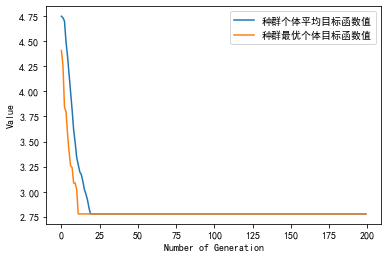

种群信息导出完毕。
最短路程为：2.778215287368279
最佳路线为：
A J I H G F E D C B A 
有效进化代数：200
最优的一代是第 12 代
评价次数：10000
时间已过 0.3970301151275635 秒


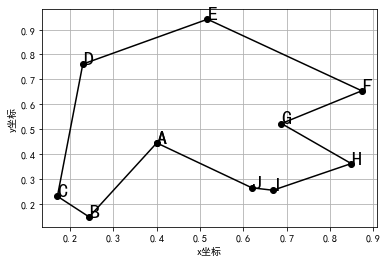

In [4]:
# -*- coding: utf-8 -*-
import numpy as np
import geatpy as ea # import geatpy
import matplotlib.pyplot as plt

"""
    一个带约束的单目标旅行商问题：
    有十座城市：A, B, C, D, E, F, G, H, I, J，坐标如下：
        X      Y
    [[0.4,  0.4439],
     [0.2439,0.1463],
     [0.1707,0.2293],
     [0.2293,0.761],
     [0.5171,0.9414],
     [0.8732,0.6536],
     [0.6878,0.5219],
     [0.8488,0.3609],
     [0.6683,0.2536],
     [0.6195,0.2634]]
    某旅行者从A城市出发，想逛遍所有城市，并且每座城市去且只去一次，最后要返回出发地，
而且需要从G地拿重要文件到D地，另外要从F地把公司的车开到E地，那么他应该如何设计行程方案，才能用
最短的路程来满足他的旅行需求？
    分析：在这个案例中，旅行者从A地出发，把其他城市走遍一次后回到A地，因此我们只需要考虑中间途
径的9个城市的访问顺序即可。这9个城市需要排列组合选出满足约束条件的最优的排列顺序作为最终的路线方案。
"""
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        M = 1 # 初始化M（目标维数）
        maxormins = [1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 9 # 初始化Dim（决策变量维数）
        varTypes = [1] * Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [1] * Dim # 决策变量下界
        ub = [9] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 新增一个属性存储旅行地坐标
        self.places = np.array([[0.4,0.4439],
                               [0.2439,0.1463],
                               [0.1707,0.2293],
                               [0.2293,0.761],
                               [0.5171,0.9414],
                               [0.8732,0.6536],
                               [0.6878,0.5219],
                               [0.8488,0.3609],
                               [0.6683,0.2536],
                               [0.6195,0.2634]])
    
    def aimFunc(self, pop): # 目标函数
        x = pop.Phen # 得到决策变量矩阵
        # 添加从0地出发且最后回到出发地
        X = np.hstack([np.zeros((x.shape[0], 1)), x, np.zeros((x.shape[0], 1))]).astype(int)
        
        ObjV = [] # 存储所有种群个体对应的总路程
        for i in range(X.shape[0]):
            journey = self.places[X[i], :] # 按既定顺序到达的地点坐标
            distance = np.sum(np.sqrt(np.sum(np.diff(journey.T)**2, 0))) # 计算总路程
            ObjV.append(distance)
        pop.ObjV = np.array([ObjV]).T # 把求得的目标函数值赋值给种群pop的ObjV
        # 找到违反约束条件的个体在种群中的索引，保存在向量exIdx中（如：若0、2、4号个体违反约束条件，则编程找出他们来）
        exIdx1 = np.where(np.where(x == 3)[1] - np.where(x == 6)[1] < 0)[0]
        exIdx2 = np.where(np.where(x == 4)[1] - np.where(x == 5)[1] < 0)[0]
        exIdx = np.unique(np.hstack([exIdx1, exIdx2]))
        pop.CV = np.zeros((pop.sizes, 1))
        pop.CV[exIdx] = 1 # 把求得的违反约束程度矩阵赋值给种群pop的CV
        
        
if __name__ == '__main__':
    """================================实例化问题对象============================"""
    problem = MyProblem() # 生成问题对象
    """==================================种群设置==============================="""
    Encoding = 'P'        # 编码方式，采用排列编码
    NIND = 50             # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """================================算法参数设置============================="""
    myAlgorithm = ea.soea_SEGA_templet(problem, population) # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 200 # 最大进化代数
    myAlgorithm.mutOper.Pm = 0.5 # 变异概率
    myAlgorithm.drawing = 1 # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）
    """===========================调用算法模板进行种群进化======================="""
    [population, obj_trace, var_trace] = myAlgorithm.run() # 执行算法模板
    population.save() # 把最后一代种群的信息保存到文件中
    """===============================输出结果及绘图============================"""
    # 输出结果
    best_gen = np.argmin(problem.maxormins * obj_trace[:, 1]) # 记录最优种群个体是在哪一代
    best_ObjV = np.min(obj_trace[:, 1])
    print('最短路程为：%s'%(best_ObjV))
    print('最佳路线为：')
    best_journey = np.hstack([0, var_trace[best_gen, :], 0])
    for i in range(len(best_journey)):
        print(chr(int(best_journey[i]) + 65), end = ' ')
    print()
    print('有效进化代数：%s'%(obj_trace.shape[0]))
    print('最优的一代是第 %s 代'%(best_gen + 1))
    print('评价次数：%s'%(myAlgorithm.evalsNum))
    print('时间已过 %s 秒'%(myAlgorithm.passTime))
    # 绘图
    plt.figure()
    plt.plot(problem.places[best_journey.astype(int), 0], problem.places[best_journey.astype(int), 1], c = 'black')
    plt.plot(problem.places[best_journey.astype(int), 0], problem.places[best_journey.astype(int), 1], 'o', c = 'black')
    for i in range(len(best_journey)):
        plt.text(problem.places[int(best_journey[i]), 0], problem.places[int(best_journey[i]), 1], chr(int(best_journey[i]) + 65), fontsize=20)
    plt.grid(True)
    plt.xlabel('x坐标')
    plt.ylabel('y坐标')
    plt.savefig('roadmap.svg', dpi=600, bbox_inches='tight')